In [1]:
import numpy as np
from numpy import tanh
import matplotlib.pyplot as plt
import random
from math import sqrt
from model import Model
from rbm import RBM
from rbm_operator import Operator, Sx_, Sy_, Sz_, SzSz_, set_h_Hamiltonian, set_J1_Hamiltonian, set_J2_Hamiltonian

# Simple attempt to implement a variational quantum state calculation 

Reminder: the operators are defined as 
$$S\cdot S = S_x \cdot S_x + S_y \cdot S_y + S_z \cdot S_z = \frac{1}{2} (S_+ \cdot S_- + S_- \cdot S_+) + S_z \cdot S_z$$

where $S_z = \frac{\hbar}{2} \begin{pmatrix} 1 & 0 \\ 0  & -1 \end{pmatrix}$, $S_+ = \hbar \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} = S_x + S_y$, $S_- = \hbar \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} = S_x - S_y$. A singlet state has energy $-3J/4$ and a triplet state has energy $J/4$

As an example, we start with a very simple J1/J2 Heisenberg spin chain

We define a class "model" that contains a Hamiltonian and a rule for generating spins according to the MSMS algorithm.

We have something to obtain the wavefunction amplitude $\psi_\theta(s)$ from the spin configuration $s$ that depends on some amplitude $\theta$

From  $\psi_\theta(s)$ for the given spin configuration, we can produce an estimate of the energy of the variational ground state.

Then we can perform a stochastic gradient descent based on it.

# Implementation of the RBM class

After having a class of spin and Hamiltonian, consider a wavefunction object, take takes a spin and returns a number. The variational quantum state is defined as 

\begin{align*}
\Psi_M(S;W) = \sum_{h_i} e^{\sum_j a_j \sigma^z_j + \sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma^{z}_j}
\end{align*}

Here the free parameters of the models are $a_i, b_, W_{ij}$ and $h_1, \dots, h_M$ represents auxilliary spin variables in the network. The internal spins can be explicited traced out to read

\begin{align*}
\Psi(S;W) = e^{\sum_j a_j \sigma^z_j} \times \Pi_{i=1}^M F_i(S)
\end{align*}

where

\begin{align*}
F_i(S) = 2\cosh\left[ b_i + \sum_J W_{ij} \sigma^z_j\right] =  2\cosh\theta_i
\end{align*}

The object would be an NN (most basic example includes the Carleo RBM, which actually has an analytical form). $a_j$ is the visible layer with the physical spins, $b_i$ is the hidden layer with an arbitrary layer of hidden spins, while $W_{ij}$ is a weight connecting the physical and hidden spins.

I need a function to compute the variational energy. A function to give gradient. And a function to do the gradient descent.


# Operators and derivatives: 

Noting that an operator dcdan be approximated by its local value

\begin{align*}
O_{loc}(s) = \sum_{s, s'}  \left< s\middle| O \middle| s' \right>\frac{\left<s' \middle| \Phi_\theta\right>}{\left<s \middle| \Phi_\theta\right>}
\end{align*}

and an operator's expectation value can be reasonably approximated by 

\begin{align*}
\left<O \right> = \sum_{s} P(s) O_{loc}(s) \approx \frac{1}{M} \sum_{s_i} O_{loc}(s_i)
\end{align*}

Now consider the energy minimization. Let $O_p(s) = \frac{\partial}{\partial \theta_p} \log \left<s\middle|\Psi_\theta\right> = \left<s\middle|O_p \middle| s\right> $,

\begin{align*}
\frac{\partial E(\theta)}{\partial \theta_p} &= 2 \Re \left[ \left\langle E_{\text{loc}}(\mathbf{s}) O^*(\mathbf{s}) \right\rangle - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle \left\langle O^*(\mathbf{s}) \right\rangle \right] \\
&= 2 \Re \left[ \left\langle (E_{\text{loc}}(\mathbf{s}) - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle) O^*(\mathbf{s}) \right\rangle \right]
\end{align*}

To evaluate the derivatives, note that 

\begin{align*}
O_{a_i} = \frac{\partial}{\partial a_i} \log \left<s\middle|\Psi_\theta\right> &= \sigma_i^z \\
O_{b_j} = \frac{\partial}{\partial b_j} \log \left<s\middle|\Psi_\theta\right> &= \tanh(\theta_j(S)) \\
O_{W_{ij}} = \frac{\partial}{\partial W_{ij}} \log \left<s\middle|\Psi_\theta\right> &= \sigma^z_i\tanh(\theta_j(S))
\end{align*}

It follows that the gradient is given by (up to proportionality factors)

\begin{align*}
\frac{\partial E(\theta)}{\partial a_i}  &= \left[ \left\langle E_{\text{loc}}(\mathbf{s}) \sigma_i^z \right\rangle - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle \left\langle \sigma_i^z \right\rangle \right] \\
\frac{\partial E(\theta)}{\partial b_j}  &= \left[ \left\langle E_{\text{loc}}(\mathbf{s}) \tanh(\theta_j(s)) \right\rangle - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle \left\langle \tanh(\theta_j(s)) \right\rangle \right] \\
\frac{\partial E(\theta)}{\partial W_{ij}}  &= \left[ \left\langle E_{\text{loc}}(\mathbf{s}) \sigma^z_i\tanh(\theta_j(s)) \right\rangle - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle \left\langle \sigma^z_i\tanh(\theta_j(s)) \right\rangle \right]
\end{align*}


Technically, I can use the naive gradient descent. But it tends to have poor convergence because the wavefunction is highly non-linear and correlated. Stchastic reconfiguration is known to have better performance. 

## Sanity check: expectation value of operators 

### Two-site operators (SzSz only, for now)

In [6]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <SzSz|ud__|SzSz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), np.array([[[0, 1], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|dd__|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <SzSz|ud__|SzSz> is (-0.25+0j) with standard deviation 0.0
The average expectation  <Sz|dd__|Sz> is (0.25+0j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.155+0j))


### One-site operator (Sz makes sense. Unsure if Sx does, but I'll sweep it under the rug for now.)

In [7]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sz_(0,0,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sz_(0,0,model), np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sz_(0,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is (0.5+2.661629416864979e-17j) with standard deviation 3.0814879110195774e-33
The average expectation  <Sz|d___|Sz> is (-0.5+0j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.024999999999999984+2.216197069250011e-18j))


In [8]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is (-1+0j) with standard deviation 0.0
The average expectation  <Sz|d___|Sz> is 0j with standard deviation 0.0
The average expectation for a 2:1 mixed state is 0j)


In [9]:
operator = Operator(model)
for i in range(2):
    for j in range(2):
        operator += Sz_(i, j, model)
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(operator, np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(operator, np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(operator, batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is 0j with standard deviation 0.0
The average expectation  <Sz|d___|Sz> is 0j with standard deviation 0.0
The average expectation for a 2:1 mixed state is (1.5150000000000001+0j))


In [10]:
#NB: This assumes that the spin is up for probability 2/3 and down for probabilty 1/3
#If you set them to be the same the spin expectation is 1/2, which checks out for |up>+|dn>
model = Model(2,3)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sx_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation <Sx|u___|Sx> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sx_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation  <Sx|d___|Sx> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(100) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sx_(0,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sx|u___|Sx> is (0.27052722383953354-0.3146306741451852j) with standard deviation 0.0
The average expectation  <Sx|d___|Sx> is (0.27052722383953354-0.3146306741451852j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.22609919571493195+0.041158037312519546j))


In [11]:
model = Model(2,3)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sy_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation <Sy|u___|Sy> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sy_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation  <Sy|d___|Sy> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sy_(1,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sy|u___|Sy> is (0.0055333473245139375-0.6675393938788688j) with standard deviation 1.1103585416259206e-16
The average expectation  <Sy|d___|Sy> is (0.0055333473245139375-0.6675393938788688j) with standard deviation 1.1103585416259206e-16
The average expectation for a 2:1 mixed state is (0.10322278215222992-0.38331483265713673j))


# Implementation of the learning process

Idea:

For each iteration:

Start with a set of weights.

For each weight, initialize the batch of state configurations based on the MCMC. For each state, get the amplitude. The combination gives an estimation of energy. This energy generates an estimation of gradient descent. Change the weight. 



## Pure J hamiltonian

In [2]:
model = Model(2,3)
rbm = RBM(model)
Ham =  set_J1_Hamiltonian(model, J = 4)
weight = 5
#rbm.set_evaluate_function(rbm.evaluate_function_dummy(weight))

N = 5000
test = [rbm.expectation_value_batch(Ham, rbm.create_batch(N)) for _ in range(5)]
print(f"The average energy is {np.mean(test)} with standard deviation {np.std(test)}")

batch = rbm.create_batch(N) 
print(f"The spin distributions are {np.average(batch, axis=0)}")

KeyboardInterrupt: 

In [2]:
N = 1000
model = Model(2,3)
rbm = RBM(model)
Ham =  set_J1_Hamiltonian(model, J = 4)
gamma = 1
rbm.train(Ham, gamma, N = 1000, n_iter = 20)

Updating weights at iteration 0
[[17.71      +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         24.36      +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         24.84      +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 ...
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.25737829+0.58039791j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          1.76556573+0.39438617j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
  -0.37316803+0.66353299j]]
Current energy: (6.842705946790314+0.3722400769108576j)
Updating weights at iteration 1
[[ 0.        +0.j          0.   

LinAlgError: Singular matrix

In [5]:
batch = rbm.create_batch(N)
# Implement a Hamiltonian
Es = np.array([rbm.expectation_value(Ham, spin) for spin in batch]) 
tanhs =  np.array([tanh(rbm.theta(spin)) for spin in batch])
sigmas = np.array([rbm.model.project_spin(spin) for spin in batch])

Oais =  sigmas
Objs =  tanhs
Owijs = tanhs[:, :, np.newaxis] * sigmas[:, np.newaxis, :]
# Flatten W and concatenate a, b, W
O = np.concatenate([Oais, Objs, Owijs.reshape(N, -1)], axis=1)
mean_O = np.mean(O, axis=0)
# Compute <Oj Ok>
Oj_Ok = np.einsum('ij,ik->jk', O, O) / N
# Compute <Oj><Ok>
mean_Oj_Ok = np.outer(mean_O, mean_O)
# Correlation matrix
Skk = Oj_Ok - mean_Oj_Ok

Skk_reg = Skk + rbm.decay(1) * np.diag(np.diagonal(Skk)) #np.eye(Skk.shape[0])
Skk_inv = np.linalg.inv(Skk_reg)

LinAlgError: Singular matrix

In [29]:
np.set_printoptions(threshold=np.inf)

In [25]:
zero_indices = np.where(Oj_Ok == 0)

# Convert the indices to a list of tuples for easier interpretation
zero_locations = list(zip(zero_indices[0], zero_indices[1]))

print("Zero entries are located at:", zero_locations)

Zero entries are located at: []


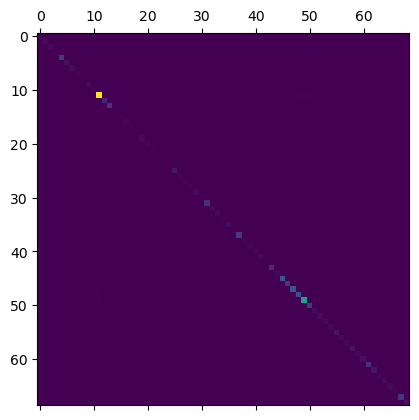

In [9]:
plt.matshow(np.abs(Skk_reg))

### Symmetry of the RBM.

Consider a translation operator working as $\sigma_j(k) = T_k \sigma_j$. An obvious requirement for translation symmetry is that $\Psi_\theta(\sigma) = \Psi_\theta(T_s\sigma)$, and an obvious way to implement this is to just artificially sum over contributions on the output $\sum_i \Psi_\theta(T_{s_i}\sigma)$, but this won't improve the efficiency of the algorithm.

A more tractable wa is to use convolutions. Before we have RBM as 

\begin{align*}
\Psi_M(S;W) &= \sum_{h_i} e^{\sum_j a_j \sigma^z_j + \sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma^{z}_j}\\
\end{align*}

Now, we can rewrite it as below, where $f = 1, \alpha_s$ is a number of feature maps, and in particular $W_{j}^{(f)} $ has $\alpha_s \times N$ elements. Note that because the spins are all summed over all translations this is translation invariant.

\begin{equation}
\Psi_{\alpha}(\mathbf{S}; \mathbf{W}) = \sum_{h_{i,s}} \exp \left[ \sum_{f}^{a} \left( a^{(s)} \sum_{s}^{S} \sum_{j}^{N} \tilde{\sigma}_{j}^{z}(s) + b_{f}^{(s)} h_{f,s} + \sum_{s}^{S} \sum_{j}^{N} h_{f,s} W_{j}^{(f)} \tilde{\sigma}_{j}^{z}(s) \right) \right],
\end{equation}
